In [1]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import time
device = "gpu"

## Defining some variables

In [2]:
protoFile = r"C:\Users\birud\OneDrive - iitgn.ac.in\github\openpose_clone\models\pose\body_25\pose_deploy.prototxt"
weightsFile = r"C:\Users\birud\OneDrive - iitgn.ac.in\github\openpose_clone\models\pose\body_25\pose_iter_584000.caffemodel"

threshold = 0.2
#Body_25 model use 25 points
key_points = {
    0:  "Nose", 1:  "Neck", 2:  "RShoulder", 3:  "RElbow", 4:  "RWrist", 5:  "LShoulder", 6:  "LElbow",
    7:  "LWrist", 8:  "MidHip", 9:  "RHip", 10: "RKnee", 11: "RAnkle", 12: "LHip", 13: "LKnee",
    14: "LAnkle", 15: "REye", 16: "LEye", 17: "REar", 18: "LEar", 19: "LBigToe", 20: "LSmallToe",
    21: "LHeel", 22: "RBigToe", 23: "RSmallToe", 24: "RHeel", 25: "Background"
}

#Body_25 keypoint pairs 
POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],     #arm, shoulder line
            [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  #2 leg
            [11,24], [11,22], [22,23], [14,21],[14,19],[19,20],    #2 foot  
            [1,0], [0,15], [15,17], [0,16], [16,18], #face
            [2,17], [5,18]
            ]  

#Body_25 PAF information 46,47? 54,55?
mapIdx = [[40,41], [48,49], [42,43], [44,45], [50,51], [52,53],
        [26,27], [32,33], [28,29], [30,31], [34,35], [36,37], [38,39], #2 leg
        [76,77], [72,73], [74,75], [70,71], [66,67], [68,69], #2 foot
        [56,57], [58,59], [62,63], [60,61], [64,65], #face
        [46,47],[54,55]   #Rshoulder<->REar, Lshoulder<->LEar 
        ]  

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

nPoints = 25

## Defining the required functions

In [3]:
def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [4]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid

        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ])
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    return valid_pairs, invalid_pairs


In [5]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score
    personwiseKeypoints = -1 * np.ones((0, nPoints + 1))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])):
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < (nPoints - 1):
                    row = -1 * np.ones(nPoints + 1)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

## Reading the image

In [6]:
img = cv2.imread(r"C:\Users\birud\OneDrive - iitgn.ac.in\github\Pose-estimation\files\test images\three_people.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
inWidth = img.shape[1]
inHeight = img.shape[0]

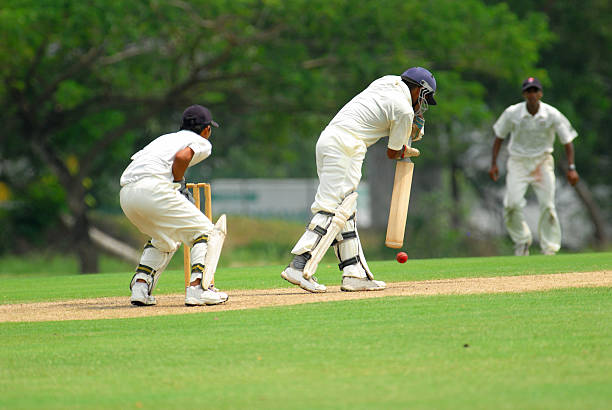

In [7]:
image_path = r'C:\Users\birud\OneDrive - iitgn.ac.in\github\Pose-estimation\files\test images\three_people.jpg'
display(Image(filename=image_path, width=500, height=500))

In [8]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
frameWidth = img.shape[1]
frameHeight = img.shape[0]

inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)
Blob = cv2.dnn.blobFromImage(img, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
net.setInput(Blob)
output = net.forward()

print("Time Taken = {}".format(time.time() - t))

Using GPU device
Time Taken = 1.0116047859191895


## Making Predictions

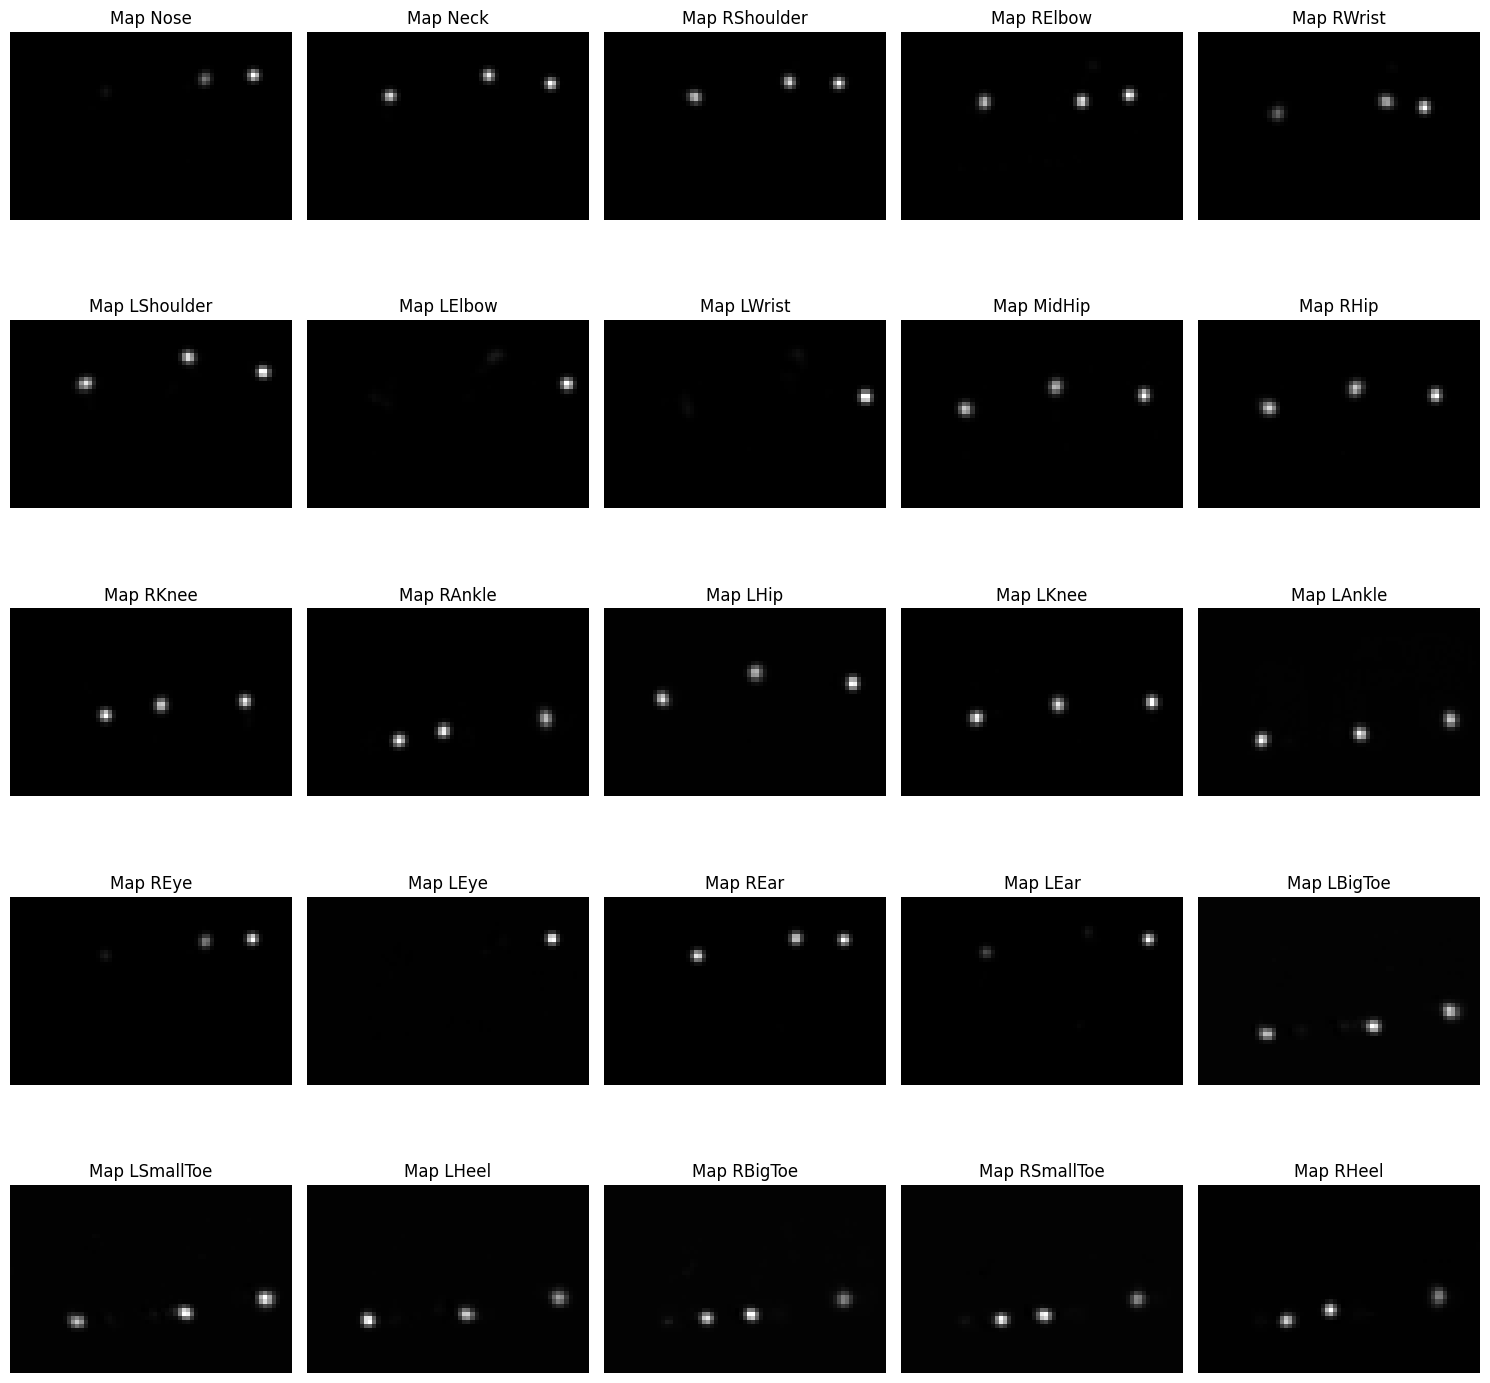

In [9]:
# Display Probability maps

# Set the number of columns for subplots
num_columns = 5

# Calculate the number of rows needed based on the total number of maps and columns
num_maps = num_images = 25
num_rows = (num_maps + num_columns - 1) // num_columns

# Create a new figure
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

for index in range(num_maps):
    probMap = output[0, index, :, :] * 255

    # Display the image using Matplotlib
    row_index = index // num_columns
    col_index = index % num_columns

    axes[row_index, col_index].imshow(probMap, cmap='gray')
    axes[row_index, col_index].set_title('Map %s' % key_points[index])
    axes[row_index, col_index].axis('off')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

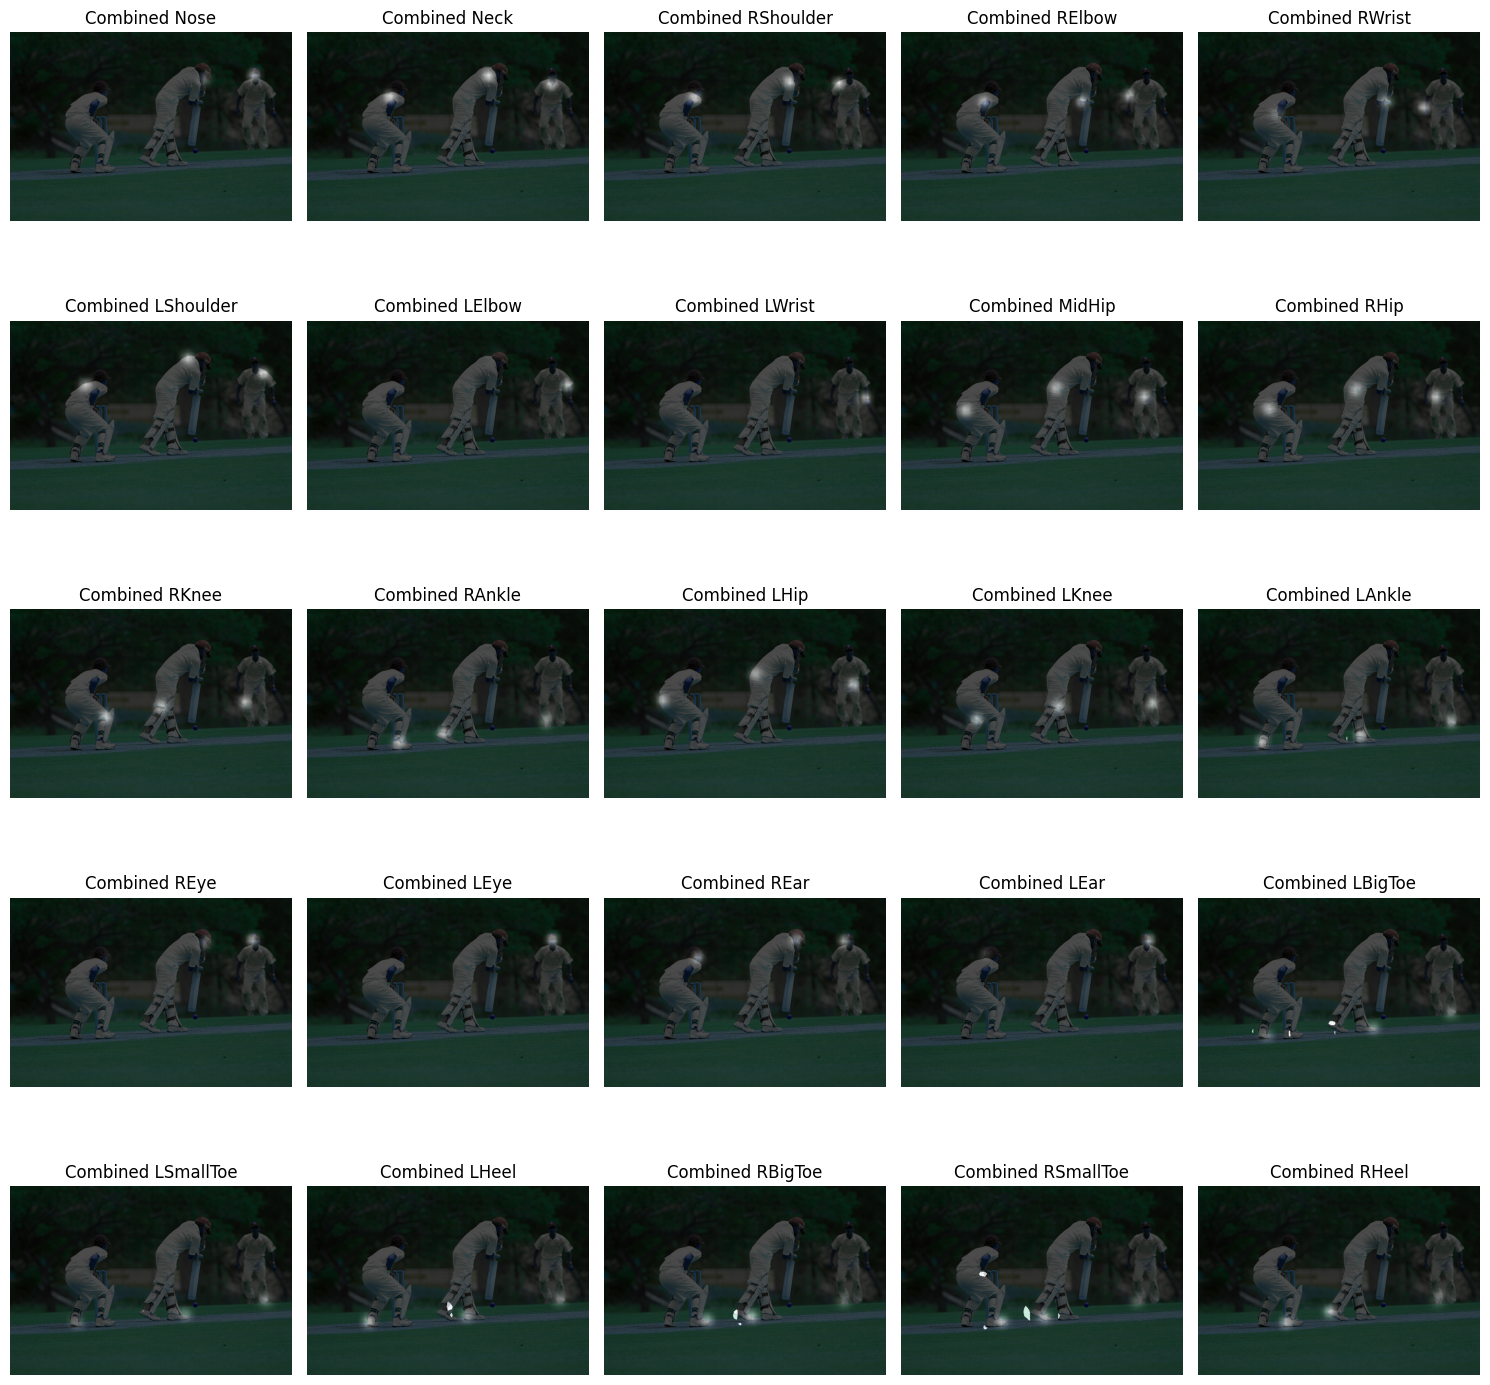

In [10]:
# Combining the probmaps with the original image
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

alpha = 0.3

for index in range(num_images):
    probMap = output[0, index, :, :]
    probMap = cv2.resize(probMap, (img.shape[1], img.shape[0]))
    
    keypoints = getKeypoints(probMap, threshold)
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)
    
    probMap = np.asarray(probMap * 255, np.uint8)
    probMap = cv2.cvtColor(probMap, cv2.COLOR_GRAY2BGR)
    dst = cv2.addWeighted(img, alpha, probMap, (1 - alpha), 0)

    # Display the combined image using Matplotlib
    row_index = index // num_columns
    col_index = index % num_columns

    axes[row_index, col_index].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    axes[row_index, col_index].set_title('Combined %s' % key_points[index])
    axes[row_index, col_index].axis('off')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

## Display Results

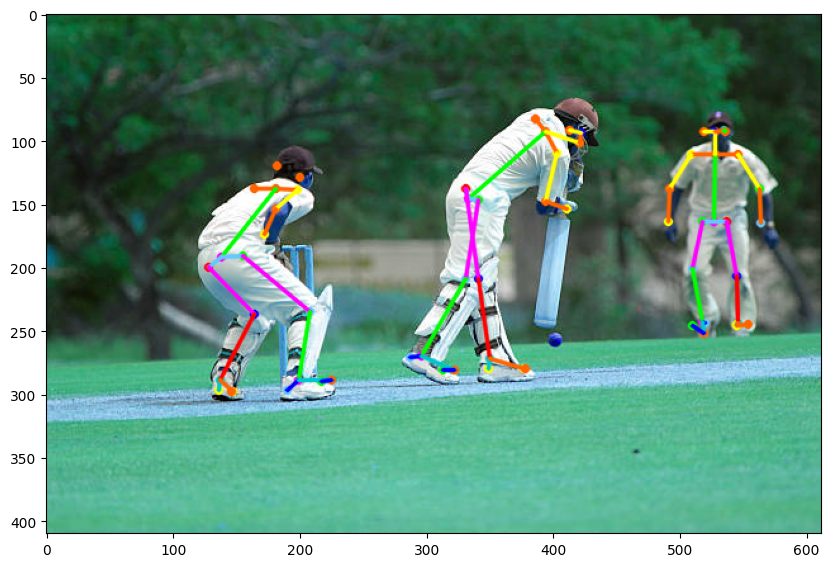

In [11]:
frameClone = img.copy()
point_radius = 3  # Adjust the radius for the keypoints
line_thickness = 2  # Adjust the thickness for the lines

for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], point_radius, colors[i % 17], -1, cv2.LINE_AA)

valid_pairs, invalid_pairs = getValidPairs(output)
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

for i in range(nPoints - 1):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i % 17], line_thickness, cv2.LINE_AA)

plt.figure(figsize=(10, 10)) 
plt.imshow(cv2.cvtColor(frameClone, cv2.COLOR_BGR2RGB))
# plt.axis('off')
plt.show()
